## Download Dataset and Unzip it

In [5]:
!unzip "df.zip"

Archive:  df.zip
  inflating: df.csv                  


## Import Librairies

In [6]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf

# Data Preparation

1. read the csv, parse dates and set the index column to the date column (can all be in one function call)
2. groupy the dataframe by year and month and sum
3. set the column name to "value"

In [7]:
### FIX ME
df = pd.read_csv("df.csv", parse_dates=True, index_col="date")
df = pd.DataFrame(df.groupby(df.index.strftime('%Y-%m')).sum()['amount'])
df.columns = ["value"]
### !FIX ME

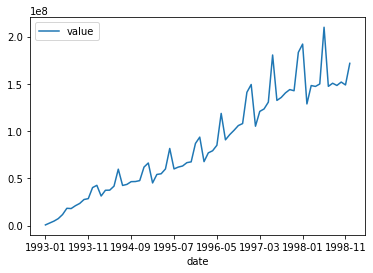

In [8]:
df.plot()

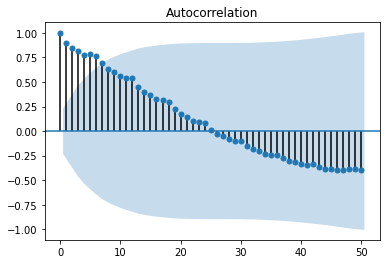

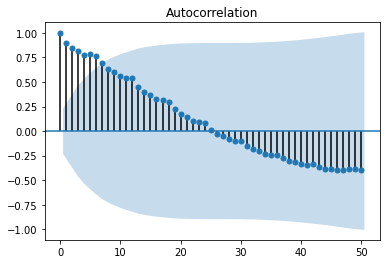

In [9]:
plot_acf(df["value"].dropna(), lags=50)

In [10]:
df.head(14)

,value
date,
1993-01,7.021576e+05
1993-02,2.726925e+06
1993-03,4.730319e+06
1993-04,7.378368e+06
1993-05,1.168075e+07
1993-06,1.829195e+07
1993-07,1.802129e+07
1993-08,2.102881e+07
1993-09,2.343870e+07


## Making the data stationary

In order our models to work, we need to make sure our data is stationary.

Here are the steps that you will need to follow:
- compute the log of the data
- differencing to get month to month variation
- differencing again to remove seasonality (approx. 12 months lag)

Again, those steps can be completed with only one function call using pandas.DataFrame features.

https://pandas.pydata.org/docs/

In [11]:
def check_stationarity(series):
    result = adfuller(series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic', 'p-value', 'Number of Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(f'{label} : {value}')
    if result[1] <= 0.05:
        print("Data is stationary")
    else:
        print("Data is not stationary")

In [12]:
### FIX ME
df_testing = df.copy()

df_testing.value = np.log(df_testing.value) # Getting log value
df_testing.value = df_testing.value.diff()
df_testing.value = df_testing.value.diff(12)
df_testing
### !FIX ME

,value
date,
1993-01,NaN
1993-02,NaN
1993-03,NaN
1993-04,NaN
1993-05,NaN
...,...
1998-08,-0.000988
1998-09,-0.051039
1998-10,-0.000599


In [13]:
check_stationarity(df_testing["value"].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.225226609716364
p-value : 7.807176920050943e-06
Number of Lags Used : 3
Number of Observations Used : 55
Data is stationary


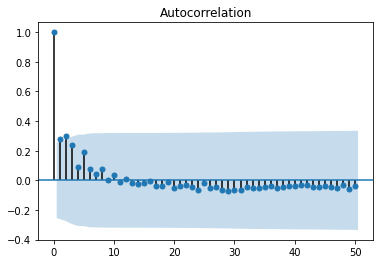

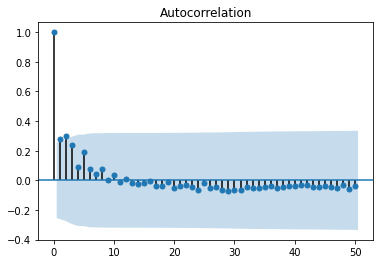

In [14]:
###
# Here you can plot the autocorrelation diagram again to see the difference
plot_acf(df_testing["value"].dropna(), lags=50)
###

## Computing the AR(p) model

We need a function that takes a value of p (remember the slides) and a dataframe.

It should return a tuple containing: (rmse, p, theta, intercept of the regression, the dataframe with prediction included)

In [36]:
def ar(p, df):
    """
    To make things easier, you will need to create as many columns as necessary to perform the regression.
    If the autoregressive order (p) is 2, you will need to add 2 columns, one with a shift of 1, and the other with a shift
    of 2.

    You then split the dataset into 2 parts: train and test (80% for train and the rest for test).

    Then you will drop the nan values, because this won't work with the regression.

    You will train the linear regression, get the coefficients and the intercept.

    Then create a new column "prediction" in your train and test datasets that will
    be filled with the predicted values.

    You compute the RMSE. You can use the mean_squared_error import above not to waste time on it.
    Of course you can write your own.

    Return [rmse, p, coefficients of the regression, intercept, pd.concat([train, test])]

    The sets need to be returned because we are using it later.
    """
    data = df.copy()
    for i in range(1, p+1):
        data[f"shift-{i}"] = data["value"].shift(i)
    train = pd.DataFrame(data[:int(0.8 * data.shape[0])])
    test  = pd.DataFrame(data[int(0.8 * data.shape[0]):])
    train = train.dropna()
    x_train = train.values[:, 1:]
    y_train = train.values[:, 0]
    lr = LinearRegression()
    lr.fit(x_train, y_train)
    x_test = test.values[:, 1:]
    train["prediction"] = x_train.dot(lr.coef_.T) + lr.intercept_
    test["prediction"] = x_test.dot(lr.coef_.T) + lr.intercept_
    rmse = np.sqrt(mean_squared_error(test['value'], test['prediction']))
    return [rmse, p, lr.coef_.T, lr.intercept_, pd.concat([train, test])]

best_rmse = 100000000
chosen_p  = -1
### FIX ME
# Iterate on values of p and take the best (lower RMSE).
for p in range(1, 21):
  [rmse, _, theta, intercept, _] = ar(p, pd.DataFrame(df_testing["value"]))
  print(f"{p} :: {rmse}")
  if rmse < best_rmse:
    best_rmse = rmse
    chosen_p = p
print(f"chosen: {chosen_p}")
### !FIX ME

1 :: 0.032388648408077265
2 :: 0.03325009798919134
3 :: 0.029558050939839802
4 :: 0.028285801000846898
5 :: 0.03151488059849384
6 :: 0.0322596083639379
7 :: 0.027590310611580772
8 :: 0.034671315188419
9 :: 0.030740362591167695
10 :: 0.03256948869494694
11 :: 0.031246634780044597
12 :: 0.03567977199974267
13 :: 0.031805101515395943
14 :: 0.03243678373356788
15 :: 0.048006580308367575
16 :: 0.060138095103115206
17 :: 0.05737216043431321
18 :: 0.11567845252209938
19 :: 0.1842163299370899
20 :: 0.13501816458472687
chosen: 7


In [37]:
[rmse, _, theta, intercept, result_prediction_df] = ar(chosen_p, pd.DataFrame(df_testing["value"]))

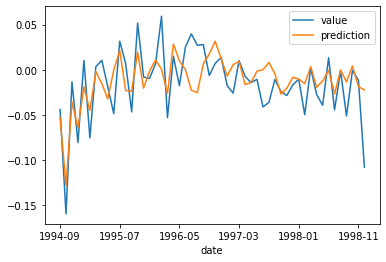

In [38]:
result_prediction_df[["value", "prediction"]].plot()

## Computing the MA model

In [43]:
def ma(q, df):
    """
    The MA function is extremely similar to the AR function.

    It is another linear regression but on residual data instead.
    """
    data = df.copy()
    ###
    # FIX ME
    data = df.copy()
    for i in range(1, q+1):
        data[f"shift-{i}"] = data["residual"].shift(i)
    train = pd.DataFrame(data[:int(0.8 * data.shape[0])])
    test  = pd.DataFrame(data[int(0.8 * data.shape[0]):])
    train = train.dropna()
    x_train = train.values[:, 1:]
    y_train = train.values[:, 0]
    lr = LinearRegression()
    lr.fit(x_train, y_train)
    x_test = test.values[:, 1:]
    train["prediction"] = x_train.dot(lr.coef_.T) + lr.intercept_
    test["prediction"] = x_test.dot(lr.coef_.T) + lr.intercept_
    rmse = np.sqrt(mean_squared_error(test['residual'], test['prediction']))
    ###
    return [rmse, q, lr.coef_.T, lr.intercept_, pd.concat([train, test])]

In [44]:
### FIX ME
# Here you generate the residuals data by substracting the AR(p) prediction to the true values
residuals = pd.DataFrame()
residuals["residual"] = result_prediction_df["value"] - result_prediction_df["prediction"]
### !FIX ME

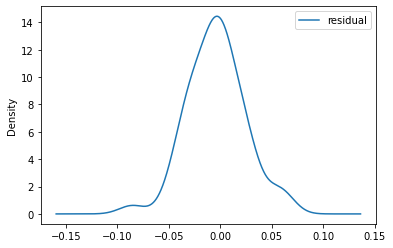

In [45]:
# The following function will display the distribution of the residual

residuals.plot(kind="kde")

In [46]:
best_rmse = 100000000
chosen_q  = -1

### FIX ME
# Again iterate on values of q and take the best (lower RMSE).
for q in range(1, 21):
  [rmse, _, theta, intercept, _] = ma(q, pd.DataFrame(residuals["residual"]))
  print(f"{q} :: {rmse}")
  if rmse < best_rmse:
    best_rmse = rmse
    chosen_q = q
print(f"chosen: {chosen_q}")
### !FIX ME

1 :: 0.031984021565677506
2 :: 0.032989430227765876
3 :: 0.03408338236742454
4 :: 0.03450430781256752
5 :: 0.035351319086375566
6 :: 0.035867081911430024
7 :: 0.03718574869751802
8 :: 0.037286951086643504
9 :: 0.038078751114832825
10 :: 0.03736485660629247
11 :: 0.037903042892427484
12 :: 0.04337445915271738
13 :: 0.04437325836722886
14 :: 0.04476468282266099
15 :: 0.05060810713234901
16 :: 0.06092672600492432
17 :: 0.08179716326772937
18 :: 0.05801032252743036
19 :: 0.10396473122743248
20 :: 0.19983309815261582
chosen: 1


In [47]:
[rmse, _, theta, intercept, result_residuals_df] = ma(chosen_q, pd.DataFrame(residuals["residual"]))

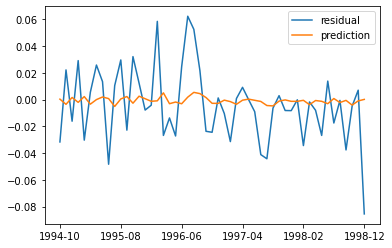

In [48]:
result_residuals_df[["residual", "prediction"]].plot()

## Forecasting

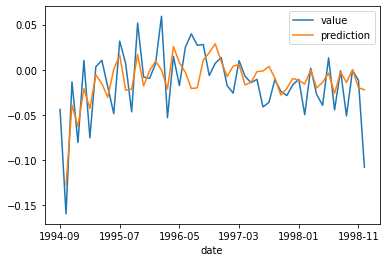

In [49]:
result_prediction_df["prediction"] += result_residuals_df["prediction"]
result_prediction_df[["value", "prediction"]].plot()

## Back to the original scale

We simply backtrack the operations we performed to make the data stationary so we get back to the original scale.

In [50]:
results = result_prediction_df.copy()
results["value"] += np.log(df).shift(1)["value"]
results["value"] += np.log(df).diff().shift(12)["value"]
results["value"] = np.exp(results["value"])
results["prediction"] += np.log(df).shift(1)["value"]
results["prediction"] += np.log(df).diff().shift(12)["value"]
results["prediction"] = np.exp(results["prediction"])

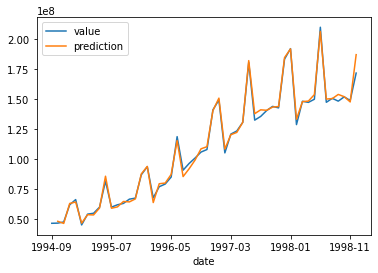

In [51]:
results[["value", "prediction"]].plot()